In [68]:
CALI_PROCESSED = r"..\..\data\processed\california_auto_processed.csv"
REPO_DIR = r"C:\Users\grego\Documents\GitHub\DS440CapstoneIndubitably"
MODEL_FP = r"C:\Users\grego\Documents\GitHub\DS440CapstoneIndubitably\models\knn_tuned.pkl"

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append(REPO_DIR)
from app_new.feature_engineering import DemoClassifier
from dataclasses import dataclass
import numpy as np

@dataclass
class Feature:
    data: pd.DataFrame | np.ndarray
    col: str
    type: str
    models: dict | None
    params: dict | None

    def __str__(self):
        return f"{self.type} ({self.col}) - {self.params}"

    __repr__ = __str__

In [70]:
cali = pd.read_csv(CALI_PROCESSED)
cali.head()

,review_id,listing_id,description,comments,sentiment,label,name,amenities
0,120328835,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['host', 'very', 'nice', 'lady', 'however', 'e...",1.8,mbad,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."
1,18794308,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['husband', 'stayed', 'gae', 'mel', '5', 'nigh...",4.0,mgood,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."
2,155950,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['drove', 'six', 'hour', 'park', 'spot', 'righ...",4.0,good,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."
3,173992,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['girlfriend', 'amazing', 'time', 'staying', '...",4.0,good,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."
4,1490950,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['amazing', 'inspiring', 'place', 'like', 'mus...",4.5,good,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."


In [71]:
# KEY ERROR: THESE NEED TO BE CONVERTED TO LISTS
cali.description = cali.description.apply(eval)
cali.comments = cali.comments.apply(eval)
cali.amenities = cali.amenities.apply(eval)
cali["name"] = cali["name"].apply(eval)

In [72]:
# load model
model = pickle.load(open(MODEL_FP, "rb"))
model

{'model': KNeighborsClassifier(leaf_size=10, n_neighbors=3),
 'combo': (amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad', 'amenity005_kitchen', 'amenity005_breakfast']},
  pca (comments) - {'n_components': 5, 'vector_size': 200},
  pca (description) - {'n_components': 10, 'vector_size': 1000})}

In [73]:
clf = DemoClassifier(MODEL_FP)
y_pred, probabilities = clf.predict_all_processed(cali)
y_pred = pd.Series(y_pred)

Loading models...
Predicting on 955 rows...
Processing row 1 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 2 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 3 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 4 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 5 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 6 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 7 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 8 of 955...
Generating amenities featu

KNeighborsClassifier(leaf_size=10, n_neighbors=3)
amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad', 'amenity005_kitchen', 'amenity005_breakfast']}
pca (comments) - {'n_components': 5, 'vector_size': 200}
pca (description) - {'n_components': 10, 'vector_size': 1000}
Californian accuracy: 63.56%


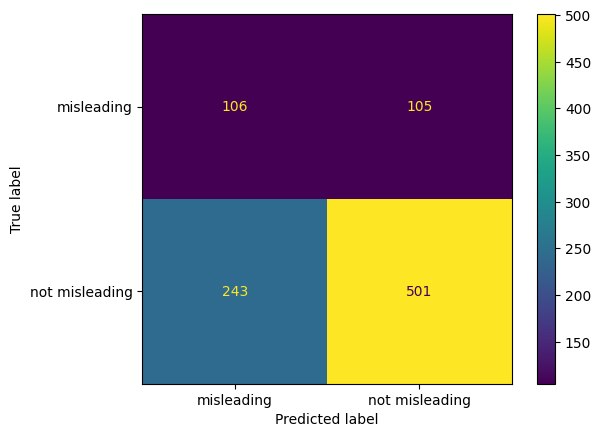

In [74]:
BINARY_LABELS = True

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# load model
with open(MODEL_FP, "rb") as f:
    model = pickle.load(f)

# print info about model and features
print(model["model"])
for feature in model["combo"]:
    print(feature)

if BINARY_LABELS:

    # combine mgood and mbad into "misleading" and good and bad into "not misleading"
    cali_adj = cali.copy()
    y_pred_adj = y_pred.copy()
    cali_adj.label = cali_adj.label.replace({"mgood": "misleading", "mbad": "misleading", "good": "not misleading", "bad": "not misleading"})
    y_pred_adj = y_pred_adj.replace({"mgood": "misleading", "mbad": "misleading", "good": "not misleading", "bad": "not misleading"})

    cm = ConfusionMatrixDisplay.from_predictions(cali_adj.label, y_pred_adj)

    # calculate the accuracy
    accuracy = accuracy_score(cali_adj.label, y_pred_adj)
    print(f"Californian accuracy: {accuracy:.2%}")

else:

    cm = ConfusionMatrixDisplay.from_predictions(cali.label, y_pred)

    # calculate the accuracy
    accuracy = accuracy_score(cali.label, y_pred)
    print(f"Californian accuracy: {accuracy:.2%}")

plt.show()

In [75]:
if BINARY_LABELS:

    true = cali_adj.label.value_counts()
    pred = y_pred_adj.value_counts()
    # calculate accuracy
    print("Accuracy:", accuracy_score(cali_adj.label, y_pred_adj))
else:
    true = cali.label.value_counts()
    pred = y_pred.value_counts()
    # calculate accuracy
    print("Accuracy:", accuracy_score(cali.label, y_pred))



# combine into a dataframe, with labels for true or predicted
true_df = pd.DataFrame({"count": true, "type": "true"})
pred_df = pd.DataFrame({"count": pred, "type": "pred"})
label_compare = pd.concat([true_df, pred_df]).reset_index()

# rename the index column to label
label_compare.rename(columns={"index": "label"}, inplace=True)
label_compare

# plot the counts
import plotly.express as px

fig = px.bar(label_compare, x="label", y="count", color="type", barmode="group")
fig.update_layout(title="True vs. Predicted Labels")
fig.show()

Accuracy: 0.6356020942408377
